# NLP

### Задание 1:

В папке с данными (data) расположен датасет bbc , который содержит 5 классов новостных статей (business, entertainment, politics, sport, tech). Вам необходимо реализовать следующее:

- Обучить любой (на ваш выбор) алгоритм классификации из классических алгоритмов машинного обучения (не нейронная сеть!) и измерить метрику качества работы модели (не забываем также проверять качество на инференсе).
- Дообучить модель DistillBert для многоклассовой классификации и проверить также качество работы алгоритма (н забываем проверять качество на инференсе). Похожий код был продемонстрирован на лекции, думаем головой, не копипастите, есть нюансы в данной задаче.
- Оформить оба решения в пайплайны. Отдаем новости – получаем метку класса и вероятность. Соскрапить или собрать вручную по пять свежих новостей с ресурса (https://www.bbc.com/news - ссылки на новости прикрепить в ноутбуке) для каждого из классов и прогнать на них пайплайны.  Получить результаты инференса пайплайнов, и оценить какое из решений лучше.

### Задание 2:

По каждому из классов (business, entertainment, politics, sport, tech) вам необходимо взять каждый класс и смоделировать распределение топиков (тем) по каждому из классов и построить визуализации. Необходимо объяснить о чем больше всего говорится в каждом из классов, то есть сделать на основании вашей работы анализ по каждому из классов. Используем любой подход, который вам известен для задачи Topic Modelling. 


## Задание 1

Импортируем библиотеки 

In [1]:
import os
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
import nltk

Импортируем данные

In [2]:
def load_data(base_path):
    categories = os.listdir(base_path)
    data = []
    for category in categories:
        files = glob.glob(os.path.join(base_path, category, "*.txt"))
        for file in files:
            with open(file, "r", encoding="latin-1") as f:
                text = f.read().strip()
                data.append((text, category))
    return pd.DataFrame(data, columns=["text", "category"])

data = load_data("bbc")
category_mapping = {cat: i for i, cat in enumerate(data["category"].unique())}
data["label"] = data["category"].map(category_mapping)

Из ML подхода я решил выбрать Наивный Баис с TF-IDF

In [3]:
class NaiveBayesClassifier:
    def __init__(self):
        self.pipeline = Pipeline([
            ("tfidf", TfidfVectorizer()),
            ("clf", MultinomialNB()),
        ])
    
    def train(self, X_train, y_train):
        self.pipeline.fit(X_train, y_train)
    
    def predict(self, text):
        probs = self.pipeline.predict_proba([text])[0]
        predicted_class = self.pipeline.predict([text])[0]
        return predicted_class, probs

X_train, X_test, y_train, y_test = train_test_split(data["text"], data["label"], test_size=0.2, random_state=42)
nb_classifier = NaiveBayesClassifier()
nb_classifier.train(X_train, y_train)

print("Accuracy (Naive Bayes):", accuracy_score(y_test, nb_classifier.pipeline.predict(X_test)))
print(classification_report(y_test, nb_classifier.pipeline.predict(X_test)))
print({value: key for key, value in category_mapping.items()})

Accuracy (Naive Bayes): 0.9393258426966292
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       110
           1       0.98      0.80      0.88        70
           2       0.90      0.95      0.92        82
           3       0.91      1.00      0.95        94
           4       0.96      0.96      0.96        89

    accuracy                           0.94       445
   macro avg       0.94      0.93      0.93       445
weighted avg       0.94      0.94      0.94       445

{0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'}


FineTune DistilBert

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [6]:
class BBCDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = tokenizer(self.texts[idx], truncation=True, padding=True, max_length=512, return_tensors="pt")
        return {"input_ids": encoding["input_ids"].squeeze(),
                "attention_mask": encoding["attention_mask"].squeeze(),
                "labels": torch.tensor(self.labels[idx], dtype=torch.long)}

In [21]:
class DistilBERTClassifier:
    def __init__(self):
        self.model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(category_mapping)).to(device)
        self.tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
        self.trainer = None

    def train(self, train_dataset, test_dataset):

        training_args = TrainingArguments(
            output_dir='./results',
            num_train_epochs=2,
            per_device_train_batch_size=8,
            per_device_eval_batch_size=8,
            logging_steps=10
        )
        
        self.trainer = Trainer(
            model=self.model,
            args=training_args, 
            train_dataset=train_dataset, 
            eval_dataset=test_dataset, 
            tokenizer=self.tokenizer
        )
        
        self.trainer.train()
    
    def predict(self, text):
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = self.model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()[0]
            predicted_class = np.argmax(probs)
        return predicted_class, probs

In [22]:
train_dataset = BBCDataset(X_train.tolist(), y_train.tolist())
test_dataset = BBCDataset(X_test.tolist(), y_test.tolist())

distilbert_classifier = DistilBERTClassifier()
distilbert_classifier.train(train_dataset, test_dataset)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_700\4149129310.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  self.trainer = Trainer(


Step,Training Loss
10,1.504200
20,1.048700
30,0.582100
40,0.332400
50,0.150700
60,0.190600
70,0.108800
80,0.045800
90,0.207800
100,0.212700


In [18]:
distilbert_classifier.evaluate()

Парсим текст с BBC

In [10]:
import requests
from bs4 import BeautifulSoup

def parcer_bbc_news(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    title = soup.find('h1').text.strip()
    text = ' '.join([p.text.strip() for p in soup.find_all('p')])
    return title + ' ' + text

news_urls = {
    'business': ["https://www.bbc.com/news/articles/c4g7vq29g74o","https://www.bbc.com/news/articles/cm2y811g1dgo","https://www.bbc.com/news/articles/cqjdg4x08ylo","https://www.bbc.com/news/articles/cz9n4yzx43vo","https://www.bbc.com/news/articles/ce8y2eez8y2o"],
    'entertainment': ['https://www.bbc.com/culture/article/20250130-10-best-films-to-watch-in-february', 'https://www.bbc.com/news/articles/c0eg99qjynvo', 'https://www.bbc.com/culture/article/20250306-who-is-cindy-lee-pops-most-mysterious-sensation', 'https://www.bbc.com/travel/article/20250306-why-travellers-are-seeking-out-guilt-free-safaris', 'https://www.bbc.com/travel/article/20250115-the-25-best-places-to-travel-in-2025'],
    'politics': ['https://www.bbc.com/news/articles/cvg18p812ggo', 'https://www.bbc.com/news/articles/clyd49dxyxxo', 'https://www.bbc.com/news/articles/cn891505zz8o', 'https://www.bbc.com/news/articles/c0kgpyz3mmpo', 'https://www.bbc.com/news/articles/c4gm5dr95jqo'],
    'sport': ['https://www.bbc.com/sport/football/articles/c3d80p2v0x9o', 'https://www.bbc.com/sport/cricket/articles/c337m7lldy2o', 'https://www.bbc.com/sport/football/articles/c07zvx122jjo', 'https://www.bbc.com/sport/horse-racing/articles/cwygpwxpdeyo', 'https://www.bbc.com/sport/articles/cjevzl9v58yo'],
    'tech': ['https://www.bbc.com/news/articles/cx20d3r7p5do', 'https://www.bbc.com/news/articles/ckgzm1lgv22o', 'https://www.bbc.com/future/article/20250306-the-future-of-conservation-might-be-in-vr-headsets', 'https://www.bbc.com/news/articles/cr52rey0ng8o', 'https://www.bbc.com/news/articles/c62x5k44rl0o']
}

new_news = []
for category, urls in news_urls.items():
    for url in urls:
        text = parcer_bbc_news(url)
        new_news.append({'text': text, 'url': url, 'category': category})

new_df = pd.DataFrame(new_news)

Тут делаем предикт по спаршеным новостям

In [23]:
new_df_copy = new_df.copy()

def NB_predict_row(row):
    predicted_class, probs = nb_classifier.predict(row['text'])
    predicted_category = {v: k for k, v in category_mapping.items()}[predicted_class]
    return pd.Series([predicted_category, max(probs)])


def DistBERT_predict_row(row):
    predicted_class, probs = distilbert_classifier.predict(row['text'])
    predicted_category = {v: k for k, v in category_mapping.items()}[predicted_class]
    return pd.Series([predicted_category, max(probs)])


new_df_copy[['NB_predicted_class', 'NB_probs']] = new_df_copy.apply(NB_predict_row, axis=1)
new_df_copy[['DistBER_predicted_class', 'DistBER_probs']] = new_df_copy.apply(DistBERT_predict_row, axis=1)

Решил немного визуализировать результаты

In [24]:
def highlight_discrepancies(row):
    styles = [''] * len(row)
    if row['category'] != row['NB_predicted_class']:
        styles[row.index.get_loc('NB_predicted_class')] = 'background-color: red'
    if row['category'] != row['DistBER_predicted_class']:
        styles[row.index.get_loc('DistBER_predicted_class')] = 'background-color: red'
    return styles

# Применяем стилизацию
styled_df = new_df_copy[new_df_copy.columns[1:]].style.apply(highlight_discrepancies, axis=1)

styled_df

,url,category,NB_predicted_class,NB_probs,DistBER_predicted_class,DistBER_probs
0,https://www.bbc.com/news/articles/c4g7vq29g74o,business,business,0.560881,business,0.997643
1,https://www.bbc.com/news/articles/cm2y811g1dgo,business,business,0.665145,business,0.997182
2,https://www.bbc.com/news/articles/cqjdg4x08ylo,business,business,0.666863,business,0.997453
3,https://www.bbc.com/news/articles/cz9n4yzx43vo,business,sport,0.360873,politics,0.991968
4,https://www.bbc.com/news/articles/ce8y2eez8y2o,business,tech,0.801225,tech,0.996818
5,https://www.bbc.com/culture/article/20250130-10-best-films-to-watch-in-february,entertainment,entertainment,0.610094,entertainment,0.997634
6,https://www.bbc.com/news/articles/c0eg99qjynvo,entertainment,politics,0.433618,entertainment,0.977170
7,https://www.bbc.com/culture/article/20250306-who-is-cindy-lee-pops-most-mysterious-sensation,entertainment,tech,0.449308,entertainment,0.998476
8,https://www.bbc.com/travel/article/20250306-why-travellers-are-seeking-out-guilt-free-safaris,entertainment,business,0.310859,business,0.997806
9,https://www.bbc.com/travel/article/20250115-the-25-best-places-to-travel-in-2025,entertainment,business,0.338340,entertainment,0.996168


Берт показал себя намного лучше. Можно видеть, что он намного уверенее определяет категории (я про процент). Так же допущенные ошибки не столь грубые. В целом можно сказать, что новости могут относится к той категории которую он спредиктил... 

Байс во всех аспектах показал себя значительно хуже.

## Задание 2

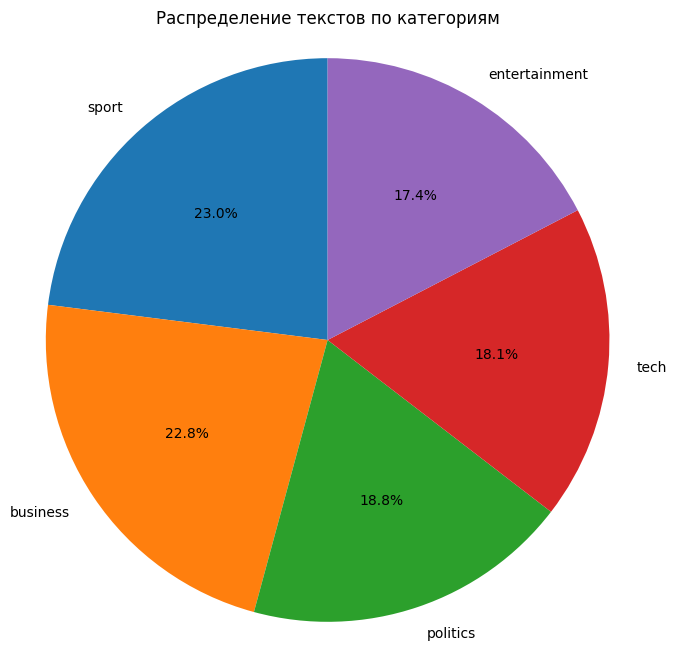

In [13]:
category_counts = data['category'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.tab10.colors)
plt.title('Распределение текстов по категориям')
plt.axis('equal')  
plt.show()

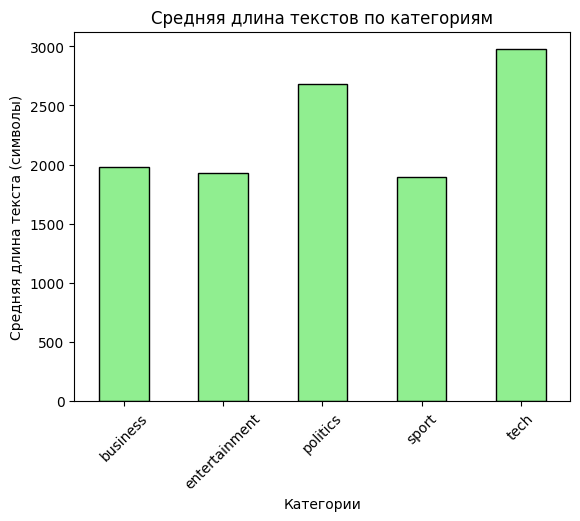

In [14]:
data['text_length'] = data['text'].apply(len)

avg_length = data.groupby('category')['text_length'].mean()

avg_length.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Средняя длина текстов по категориям')
plt.xlabel('Категории')
plt.ylabel('Средняя длина текста (символы)')
plt.xticks(rotation=45)
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


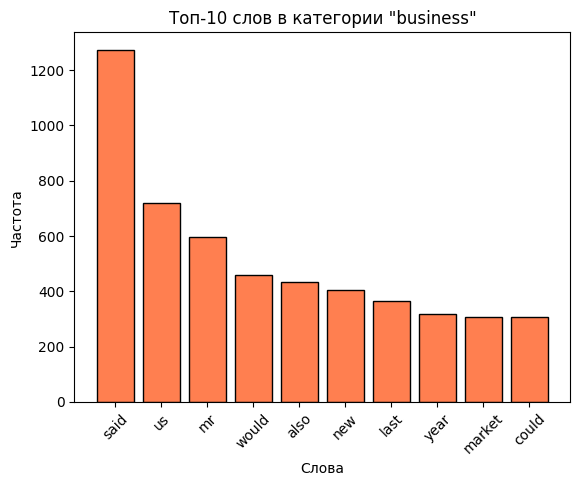

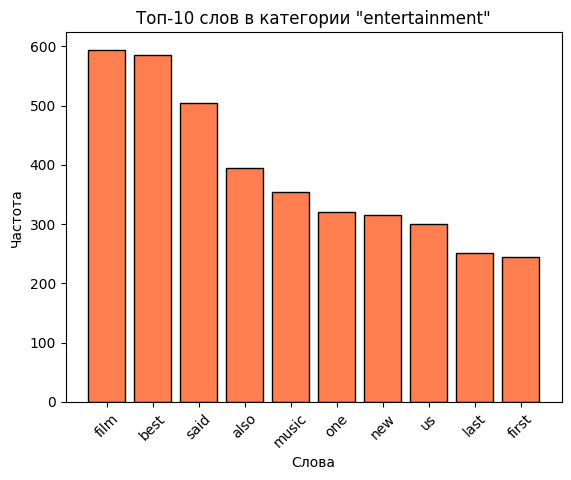

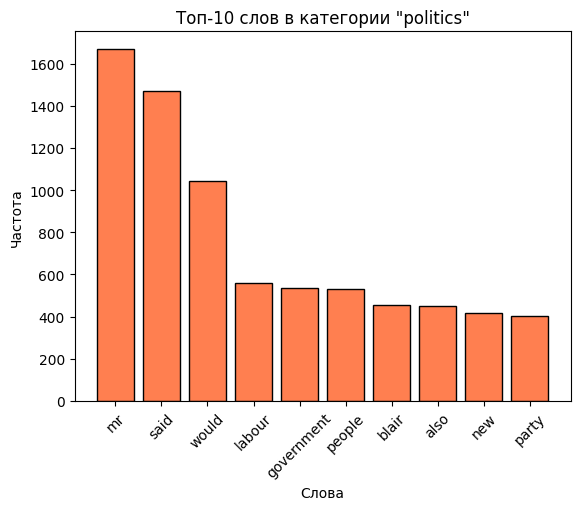

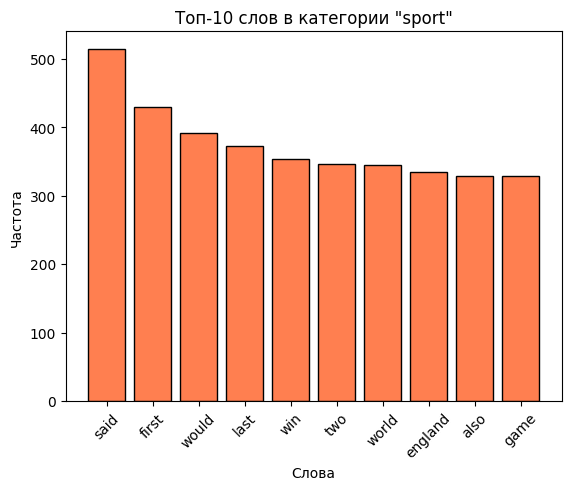

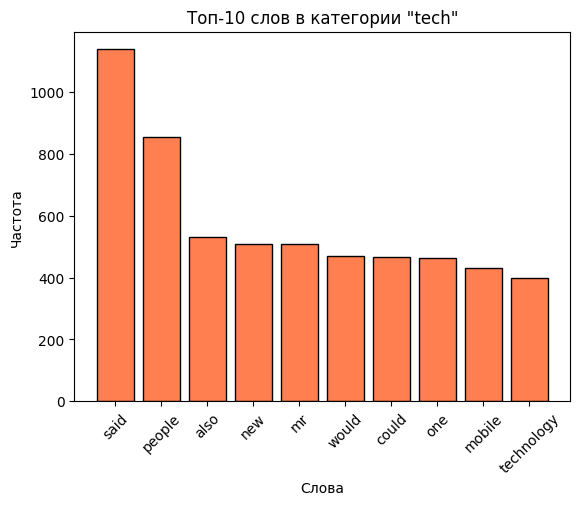

In [15]:
nltk.download('stopwords')

# Убираем стоп-слова
stop_words = set(stopwords.words('english'))

def get_word_frequencies(texts):
    words = " ".join(texts).split()
    filtered_words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
    return Counter(filtered_words).most_common(10)

# Пример для категории "tech"
for cat in data["category"].unique():
    tech_words = get_word_frequencies(data[data['category'] == cat]['text'])

    # Построение графика частотных слов
    words, counts = zip(*tech_words)
    plt.bar(words, counts, color='coral', edgecolor='black')
    plt.title(f'Топ-10 слов в категории "{cat}"')
    plt.xlabel('Слова')
    plt.ylabel('Частота')
    plt.xticks(rotation=45)
    plt.show()

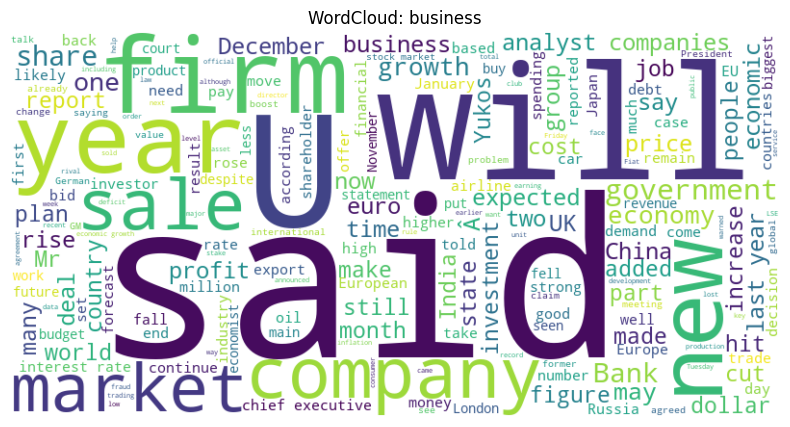

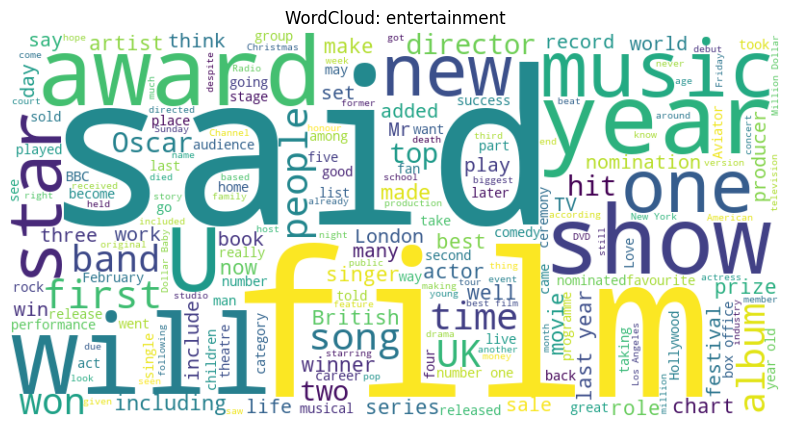

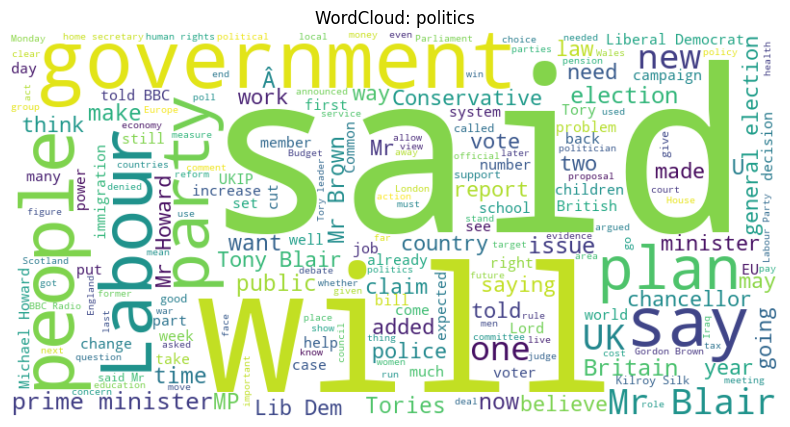

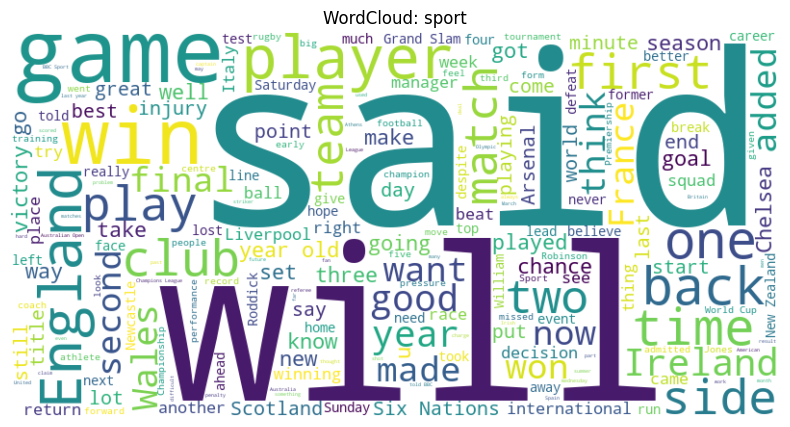

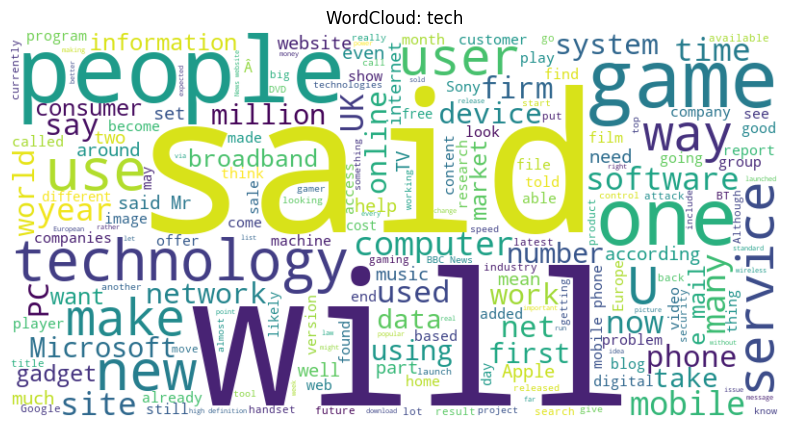

In [16]:
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

for category in data["category"].unique():
    plot_wordcloud(data[data["category"] == category]["text"].tolist(), f"WordCloud: {category}")